In [1]:
import time
import aotools
import numpy as np
from astropy.io import fits
from soapy import SCI, confParse
from matplotlib import pyplot as plt

In [2]:
# Generates aberrated Point Spread functions (PSFs)
# The phase is build as linear combination of Zernike
# polynomials.

# Soapy config
SOAPY_CONF = "psf.yaml"
# Pixel size of science camera
gridsize = 128
# Observational wavelength
wavelength = 2.2e-6
# Telescope diameter
diameter = 10
# Pixel scale
pixelScale = 0.01  # [''/px]s
# WFE norm in nm
norm_rms = (wavelength)*(10**9)
# Nb of PSFs to generate
n_psfs = 10000
# Nb of Zernike to use in the generation
n_zernike = 20
# Zernike mode index (start from Z2=tip, Noll convention)
i_zernike = np.arange(2, n_zernike + 2)
# Radial mode order
o_zernike = [1,1,
             2,2,2,
             3,3,3,3,
             4,4,4,4,4,
             5,5,5,5,5,5]

In [3]:
# Update scientific camera parameters
config = confParse.loadSoapyConfig(SOAPY_CONF)
config.scis[0].pxlScale = pixelScale
config.tel.telDiam = diameter
config.calcParams()

# Circular pupil mask
mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)

# Generate the Zernike modal basis
zernike_basis = aotools.zernikeArray(n_zernike + 1, config.sim.pupilSize, norm='rms')

# Ensure reproducibility
np.random.seed(seed=42)

# Distribution
c_zernike = np.random.random((n_psfs, n_zernike)) * 2 - 1
for j in range(n_psfs):
    for i in range(n_zernike):
        c_zernike[j, i] = c_zernike[j, i] / o_zernike[i]

# Normalize to rms norm
c_zernike = np.array([c_zernike[k, :] / np.abs(c_zernike[k, :]).sum() *
                    norm_rms for k in range(n_psfs)])

# Create the PSF image, 128x128 + 2x2 padding FTT over sampling
psfObj = SCI.PSF(config, nSci=0, mask=mask)

# PSFs with aberrations
# -> In and out of focus
psfs_in = np.zeros((n_psfs, psfObj.detector.shape[0], psfObj.detector.shape[1]))
psfs_out = np.zeros((n_psfs, psfObj.detector.shape[0], psfObj.detector.shape[1]))

# Defocus 1/4 wavelength nm
defocus = (wavelength/4) * (10**9) * zernike_basis[3, :, :]

confParse.py -> calcParams: Overriding sci FOV with pxlscale


In [4]:
# Simulate propagations and save (.fits)
# Propagate aberrations
t0 = time.time()
for i in range(n_psfs):

    # In focus
    aberrations_in = np.squeeze(np.sum(c_zernike[i, :, None, None] * zernike_basis[1:, :, :], axis=0))
    psfs_in[i, :, :] = np.copy(psfObj.frame(aberrations_in))

    # Out of focus
    abberations_out = np.squeeze(aberrations_in) + defocus
    psfs_out[i, :, :] = np.copy(psfObj.frame(abberations_out))

    # Save
    outfile = "../dataset/psf_" + str(i) + ".fits"
    hdu_primary = fits.PrimaryHDU(c_zernike[i, :])
    hdu_In = fits.ImageHDU(psfs_in[i, :, :], name='INFOCUS')
    hdu_Out = fits.ImageHDU(psfs_out[i, :, :], name='OUTFOCUS')
    hdu = fits.HDUList([hdu_primary, hdu_In, hdu_Out])
    hdu.writeto(outfile, overwrite=True)

    # Logs
    if i % (int(n_psfs / 10.)) == 0:
        print('Propagation and saving in progress: ', i, '/', n_psfs)
    t_soapy = time.time() - t0
print('Propagation and saving finished in {0:2f}s'.format(t_soapy))

Propagation and saving in progress:  0 / 10000
Propagation and saving in progress:  1000 / 10000
Propagation and saving in progress:  2000 / 10000
Propagation and saving in progress:  3000 / 10000
Propagation and saving in progress:  4000 / 10000
Propagation and saving in progress:  5000 / 10000
Propagation and saving in progress:  6000 / 10000
Propagation and saving in progress:  7000 / 10000
Propagation and saving in progress:  8000 / 10000
Propagation and saving in progress:  9000 / 10000
Propagation and saving finished in 181.318942s


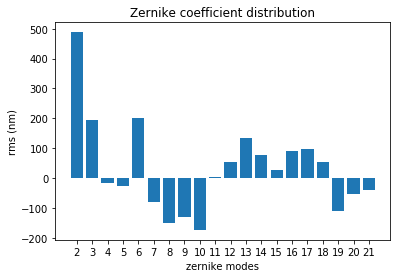

<Figure size 432x288 with 0 Axes>

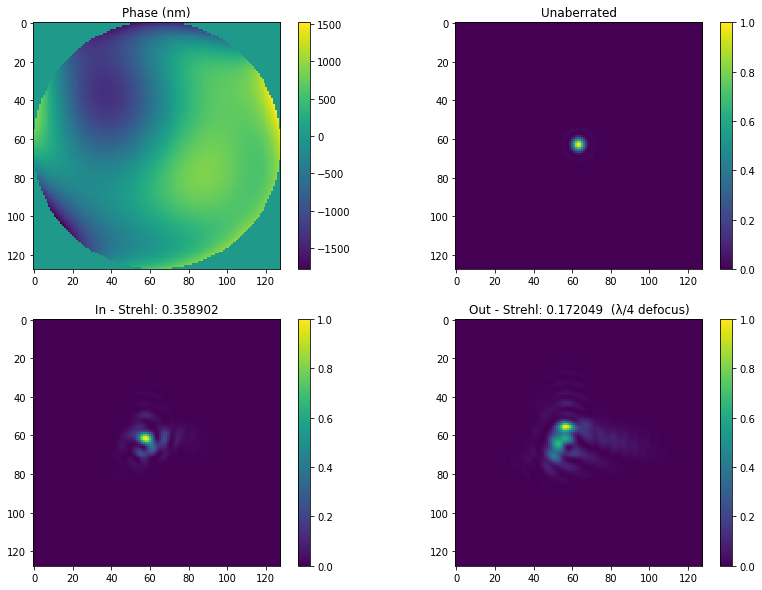

In [5]:
# Indices
id = 3534

# Plot coefficient distribution
plt.figure()
plt.bar(i_zernike, c_zernike[id]) #np.mean(c_zernike, axis=0)
plt.xticks(i_zernike)
plt.title('Zernike coefficient distribution')
plt.xlabel('zernike modes')
plt.ylabel('rms (nm)')
plt.show()

# Introduce norm, to highlight features
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import SqrtStretch, MinMaxInterval

transform = MinMaxInterval() #+ SqrtStretch()

def add_colorbar(ax, f, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    
def get_strehl(image):
    strehl = np.amax(image) / np.amax(psfObj.bestPSF)
    return strehl    

# Plot first aberrated PSF and corresponding phase
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(right=1.2)
im1 = axarr[0, 0].imshow(np.squeeze(np.sum(c_zernike[id, :, None, None] * zernike_basis[1:, :, :], axis=0)))
axarr[0, 0].set_title("Phase (nm)")
plt.colorbar(im1, ax = axarr[0, 0], fraction=0.046)
im2 = axarr[0, 1].imshow(transform(psfObj.bestPSF, clip=False))
axarr[0, 1].set_title("Unaberrated")
plt.colorbar(im2, ax = axarr[0, 1], fraction=0.046)
im3 = axarr[1, 0].imshow(transform(psfs_in[id,:,:], clip=False))
axarr[1, 0].set_title("In - Strehl: %f" % (get_strehl(psfs_in[id,:,:])))
plt.colorbar(im3, ax = axarr[1, 0], fraction=0.046)
im4 = axarr[1, 1].imshow(transform(psfs_out[id,:,:], clip=False))
axarr[1, 1].set_title("Out - Strehl: %f  (λ/4 defocus)" % (get_strehl(psfs_out[id,:,:])))
plt.colorbar(im4, ax = axarr[1, 1], fraction=0.046)
plt.show()

In [6]:
# Some Metrics

def rms_wfe(image):
    return np.sqrt(np.mean(np.square(image))-np.square(np.mean(image)))

strehl_ratios = np.zeros(2) # 1 = In, 2 = Out
rms_error = np.zeros(2)
length = psfs_in[:,:,:].shape[0]

for i in range(n_psfs):
    strehl_ratios[0] += get_strehl(psfs_in[i,:,:]) / length
    strehl_ratios[1] += get_strehl(psfs_out[i,:,:]) / length
    
    phase_in = np.squeeze(np.sum(c_zernike[i, :, None, None] * zernike_basis[1:, :, :], axis=0))
    phase_out = np.squeeze(aberrations_in) + defocus
    rms_error[0] += rms_wfe(phase_in) / length
    rms_error[1] += rms_wfe(phase_out) / length
    
print('Average Srehl ratio (peak ratio): In -> %f, Out -> %f' % (strehl_ratios[0], strehl_ratios[1]))   
print('Average RMS wfe: In -> %f nm, Out -> %f nm' % (rms_error[0], rms_error[1])) 

Average Srehl ratio (peak ratio): In -> 0.303480, Out -> 0.164770
Average RMS wfe: In -> 587.859957 nm, Out -> 906.612280 nm
